In [10]:
import os
import pandas as pd
from os.path import join

sc_dir = "/Volumes/bronkodata_work/hcpython/testsub/all SCs"
for f in os.listdir(sc_dir):
    if f.endswith("weights.csv"):
        sc = pd.read_csv(join(sc_dir, f), header=None).values

In [16]:
import hcp_utils as hcp
import matplotlib.pyplot as plt
import numpy as np

vtx, tri = hcp.mesh.inflated
vtx_data = np.insert(sc.sum(axis=1), 0, 0)[hcp.cortex_data(hcp.mmp.map_all).astype(int)]

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import art3d
from matplotlib.tri import Triangulation
from matplotlib.collections import TriMesh, PolyCollection

# Import lighting object for shading surface plots.
from matplotlib.colors import LightSource, Normalize

import nibabel as nib


def normalize_v3(arr):
    """Normalize a numpy array of 3 component vectors shape=(n,3)"""
    lens = np.sqrt(arr[:, 0] ** 2 + arr[:, 1] ** 2 + arr[:, 2] ** 2)
    arr[:, 0] /= lens
    arr[:, 1] /= lens
    arr[:, 2] /= lens
    return arr


def computeFaceNormals(vertices, faces):
    # Create an indexed view into the vertex array using the array of three indices for triangles
    tris = vertices[faces]
    # Calculate the normal for all the triangles, by taking the cross product of the vectors v1-v0, and v2-v0 in each triangle
    n = np.cross(tris[::, 1] - tris[::, 0], tris[::, 2] - tris[::, 0])
    # n is now an array of normals per triangle. The length of each normal is dependent the vertices,
    # we need to normalize these, so that our next step weights each normal equally.
    normalize_v3(n)
    return n


def computeVertexNormals(vertices, faces):
    # Create a zeroed array with the same type and shape as our vertices, i.e., per vertex normal
    norm = np.zeros(vertices.shape, dtype=vertices.dtype)

    n = computeFaceNormals(vertices, faces)
    # now we have a normalized array of normals, one per triangle, i.e., per triangle normals.
    # But instead of one per triangle (i.e., flat shading), we add to each vertex in that triangle,
    # the triangles' normal. Multiple triangles would then contribute to every vertex, so we need to normalize again afterwards.
    # The cool part, we can actually add the normals through an indexed view of our (zeroed) per vertex normal array
    norm[faces[:, 0]] += n
    norm[faces[:, 1]] += n
    norm[faces[:, 2]] += n
    normalize_v3(norm)
    return norm


# =================================================================
#  Map values to colors...
# =================================================================
def mapValues2Colors(values, cmap):
    # Convert values to colors: normalize and map to a color palette
    norm = plt.Normalize(values.min(), values.max())
    colors = cmap(norm(values))
    return colors


# =================================================================
# Functions to compute values per vertex and per face
# =================================================================
def computeFaceValues(triangles, vertexValues):
    # Change - colors are per vertex, so I make them per face.
    colorsarray = np.array([np.sum(vertexValues[face[:]] / 3) for face in triangles])
    return colorsarray


def computeVertexValues(vertices, parcellationMap, parcellationValues, numRegions):
    surfaceValues = np.zeros(len(vertices))

    for i in range(0, numRegions):
        idx = np.where(parcellationMap == i)
        surfaceValues[idx] = parcellationValues[i]
    return surfaceValues


def plotColorView(
    ax,
    cortex,
    data,
    numRegions,
    viewkey,  # The name of the view to display: 'Lh-lateral', 'Lh-medial', 'Rh-medial',
    # 'Rh-lateral', 'L-superior', 'R-superior', 'L-flat', 'R-flat'
    mode="gouraud",
    shadowed=True,
    cmap=plt.cm.coolwarm,
    l_azimuth=0,
    l_altitude=0,
    lightingBias=0.2,  # Light azimuth and altitude, and bias
    zlim=None,
    suptitle="",
    viewlabel=False,
    norm=None,
    fontSize=24,
    **kwds
):
    # ================= This part should be computed only once for all views, but this way it is easier...
    if "flat" not in viewkey:
        vtx_L, tri_L = cortex["model_L"].agg_data()
        vtx_R, tri_R = cortex["model_R"].agg_data()
    else:
        vtx_L, tri_L = cortex["flat_L"].agg_data()
        vtx_R, tri_R = cortex["flat_R"].agg_data()
    xL, yL, zL = vtx_L.T
    xR, yR, zR = vtx_R.T

    views = {
        "Lh-lateral": Triangulation(-yL, zL, tri_L),
        "Lh-medial": Triangulation(yL, zL, tri_L[::-1]),
        "Rh-medial": Triangulation(-yR, zR, tri_R[::-1]),
        "Rh-lateral": Triangulation(yR, zR, tri_R),
        "L-superior": Triangulation(xL, yL, tri_L),
        "R-superior": Triangulation(xR, yR, tri_R),
        "L-flat": Triangulation(xL, yL, tri_L),
        "R-flat": Triangulation(xR, yR, tri_R),
    }

    if "map_L" in cortex or "map_R" in cortex:
        # if we are giving a mapping between regions and vertices, let's use it!
        rm_L = cortex["map_L"]
        rm_R = cortex["map_R"]
        if viewkey in ["Lh-lateral", "Lh-medial", "L-superior"]:
            vvalues = computeVertexValues(vtx_L, rm_L, data["func_L"], numRegions)
        else:
            vvalues = computeVertexValues(vtx_R, rm_R, data["func_R"], numRegions)
    else:  # if not, it is because we were given the vertex-level values directly
        if viewkey in ["Lh-lateral", "Lh-medial", "L-superior"]:
            vvalues = data["func_L"]
        else:
            vvalues = data["func_R"]

    # ================= View-specific code...
    v = views[viewkey]
    if not viewlabel:
        plt.axis("off")
    # ================= Let's render it!
    if mode != "gouraud" or "flat" in viewkey:  # either 'L-flat' or 'R-flat'
        if "flat" in viewkey:
            kwargs = {"shading": "flat"}  # No edgecolors...
        else:
            kwargs = {"shading": "flat", "edgecolors": "k", "linewidth": 0.1}
        kwargs = kwargs | kwds
        tc = ax.tripcolor(v, vvalues, cmap=cmap, norm=norm, **kwargs)
        if zlim:
            tc.set_clim(vmin=-zlim, vmax=zlim)
    elif mode == "gouraud" and not shadowed:
        tc = ax.tripcolor(v, vvalues, cmap=cmap, shading="gouraud", norm=norm, **kwds)
        if zlim is not None:
            tc.set_clim(vmin=-zlim, vmax=zlim)
    else:  # =================
        # Ok, we have a problem: tripcolor does not seem to tolerate vertex-defined colors, something we need
        # for shadows. So let's do this "manually". Internally, I think tripcolor uses a TriMesh to render
        # the mesh if gouraud is used, but somehow the later stages do not like the outcome (when doing plt.show()).
        # So, we are going to set the colors up... manually! I hate this as much as you do! ;-)
        colors = mapValues2Colors(vvalues, cmap)  # Vertex colors

        # =============== Shadows...
        if viewkey in ["Lh-lateral", "Lh-medial", "L-superior"]:
            normals = computeVertexNormals(vtx_L, tri_L)
        else:
            normals = computeVertexNormals(vtx_R, tri_R)
        # Create a light source object for light from
        # azimuth (from north), elevation (from 0 elevation plane). Both in degrees.
        light = LightSource(l_azimuth, l_altitude)
        shaded = lightingBias + light.shade_normals(normals) * (1 - lightingBias)
        shadedColors = (colors[:, 0:3].T * shaded).T
        collection = TriMesh(
            v, facecolors=shadedColors, edgecolors="black", linewidths=0.1
        )

        # Let's paint everything!
        # fvalues = computeFaceValues(tri_L, vvalues)
        # fcolors = mapValues2Colors(fvalues, cmap)
        # collection = TriMesh(v, facecolors=fcolors, edgecolors='black', linewidths=0.1)

        # gouraud does not like edgecolors...
        collection.set_facecolor(shadedColors)
        # collection.set_facecolor()
        ax.add_collection(collection)
        # kwargs = {'shading': 'flat', 'edgecolors': 'k', 'linewidth': 0.1}
        # tc = ax.tripcolor(v, facecolors=colors, cmap=cmap, **kwargs)
        ax.autoscale_view()
    # if True:
    #     wire = TriMesh(v, edgecolors='black', linewidths=0.1)
    #     # ax.add_collection(wire)
    # =================
    ax.set_aspect("equal")
    if suptitle:
        ax.set_title(suptitle, fontsize=fontSize)
    if viewlabel:
        plt.xlabel(viewkey)
    ax.axis("off")

In [18]:
import hcp_utils as hcp

cortex = {
    "model_L": hcp.mesh.inflated_left,
    "model_R": hcp.mesh.inflated_right,
    "flat_L": hcp.mesh.flat_left,
    "flat_R": hcp.mesh.flat_right,
    "map_L": hcp.left_cortex_data(hcp.mmp.map_all),
    "map_R": hcp.right_cortex_data(hcp.mmp.map_all),
}

In [ ]:
def loadGeo():
    glassers_L = nib.load(
        Glasser360_baseFolder + "/Glasser360/" + "Glasser360.L.mid.32k_fs_LR.surf.gii"
    )
    # glassers_L = nib.load(Glasser360_baseFolder + '/Glasser360/' + 'Glasser360.L.inflated.32k_fs_LR.surf.gii')
    # glassers_L = nib.load(Glasser360_baseFolder + '/Glasser360/' + 'Glasser360.L.very_inflated.32k_fs_LR.surf.gii')

    glassers_R = nib.load(
        Glasser360_baseFolder + "/Glasser360/" + "Glasser360.R.mid.32k_fs_LR.surf.gii"
    )
    # glassers_R = nib.load(Glasser360_baseFolder + '/Glasser360/' + 'Glasser360.R.inflated.32k_fs_LR.surf.gii')
    # glassers_R = nib.load(Glasser360_baseFolder + '/Glasser360/' + 'Glasser360.R.very_inflated.32k_fs_LR.surf.gii')

    flat_L = nib.load(
        Glasser360_baseFolder + "/Glasser360/" + "Glasser360.L.flat.32k_fs_LR.surf.gii"
    )
    flat_R = nib.load(
        Glasser360_baseFolder + "/Glasser360/" + "Glasser360.R.flat.32k_fs_LR.surf.gii"
    )

    # =============== Load the information to display =====
    # atlas_l = nib.load(base_folder + '/DecoKringelbach2020/Schaefer1000_L.func.gii')
    # atlas_r = nib.load(base_folder + '/DecoKringelbach2020/Schaefer1000_R.func.gii')

    # test = nib.load(base_folder + '/Glasser360/' + 'fsaverage.L.DKT_org_Atlas.32k_fs_LR.label.gii')
    # test_dlabel = nib.load(base_folder + '/Glasser360/' + 'Glasser32k_fs_LR.dlabel.nii')
    # test_dlable2 = np.asanyarray(test_dlabel.dataobj)
    mapL = nib.load(
        Glasser360_baseFolder + "/Glasser360/" + "fsaverage.L.glasser360_fs_LR.func.gii"
    ).agg_data()
    mapR = nib.load(
        Glasser360_baseFolder + "/Glasser360/" + "fsaverage.R.glasser360_fs_LR.func.gii"
    ).agg_data()
    # test2 = nib.load(base_folder + '/Glasser360/' + 'dbs80_left.func.gii').agg_data()

    cortex = {
        "model_L": glassers_L,
        "model_R": glassers_R,
        "flat_L": flat_L,
        "flat_R": flat_R,
        "map_L": mapL,
        "map_R": mapR,
    }
    return cortex

AttributeError: 'tuple' object has no attribute 'agg_data'

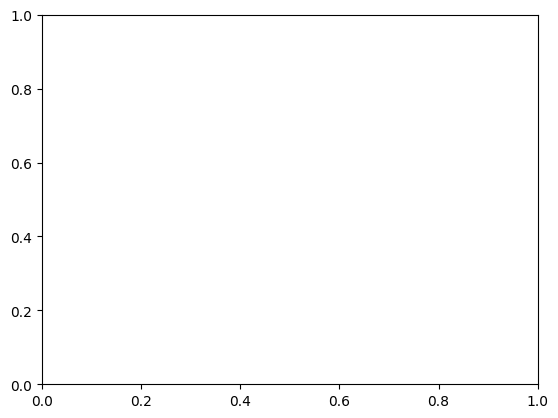

In [21]:
fig, ax = plt.subplots()

plotColorView(ax, cortex, vtx_data, numRegions=379, viewkey="Lh-lateral")